In [ ]:
#Environment Details
# !python --version
# !pip freeze

#Use when not running in Colab
# !pip install numpy==1.18.5
# !pip install tensorflow==2.3.0
# !pip install pandas==1.0.5
# !pip install seaborn==0.10.1
# !pip install matplotlib==3.2.2
# !pip install sklearn==0.0
# !pip install scipy==1.4.1

In [14]:
#Pre-requisites
!nvidia-smi
# !pip install gdown
!pip install tensorflow==2.3.0
# !pip install tensorflow-gpu

#Let’s download the data
#!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
#!tar -xvf WISDM_ar_latest.tar.gz
# !gdown https://cdap-fmg.s3.us-east-2.amazonaws.com/WISDM_WATCH_ACCEL.txt
# !gdown https://drive.google.com/uc?id=1bol4ADpBa5G7GJ3ilUxbAiRLKUh-qm4g

Sun Oct 18 18:25:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 950    WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8    16W / 115W |   1762MiB /  2048MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

You should consider upgrading via the 'c:\users\shehan\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_WATCH_ACCEL.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

# removing the 'timestamp' column.
df.pop('timestamp')
df.head() #Outputs the first few lines of Data
#df.shape #Outputs number of rows and collumns

,user_id,activity,x_axis,y_axis,z_axis
0,1600,Walking,7.091625,-0.591667,8.195502
1,1600,Walking,4.972757,-0.158317,6.696732
2,1600,Walking,3.253720,-0.191835,6.107758
3,1600,Walking,2.801216,-0.155922,5.997625
4,1600,Walking,3.770868,-1.051354,7.731027


spliting the data into training and test datasets:

In [3]:
df_train = df[df['user_id'] <= 1640]
df_test = df[df['user_id'] > 1640]

scaling the accelerometer data values:

In [4]:
# from sklearn.preprocessing import RobustScaler

# scale_columns = ['x_axis', 'y_axis', 'z_axis']

# scaler = RobustScaler()

# scaler = scaler.fit(df_train[scale_columns])

# df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
# df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [5]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [7]:
# The model is defined as a Sequential Keras model, for simplicity.
# We will define the model as having a single LSTM hidden layer. 
# This is followed by a dropout layer intended to reduce overfitting of the model to the training data. 
# Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, 
# before a final output layer is used to make predictions.


model = keras.Sequential()
model.add(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu')) #fully connected layer
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [8]:
# one epoch = one forward pass and one backward pass of all the training examples
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    shuffle=False,
)

Epoch 1/300
307/307 [==============================] - 8s 27ms/step - loss: 1.2640 - acc: 0.4331 - val_loss: 1.1462 - val_acc: 0.4596
Epoch 2/300
307/307 [==============================] - 8s 26ms/step - loss: 1.0253 - acc: 0.5176 - val_loss: 1.0184 - val_acc: 0.5073
Epoch 3/300
307/307 [==============================] - 8s 26ms/step - loss: 0.9901 - acc: 0.5243 - val_loss: 1.5521 - val_acc: 0.4106
Epoch 4/300
307/307 [==============================] - 21s 67ms/step - loss: 0.9335 - acc: 0.5475 - val_loss: 1.1465 - val_acc: 0.5679
Epoch 5/300
307/307 [==============================] - 34s 110ms/step - loss: 0.8892 - acc: 0.5897 - val_loss: 1.5987 - val_acc: 0.5647
Epoch 6/300
307/307 [==============================] - 34s 110ms/step - loss: 0.8445 - acc: 0.6132 - val_loss: 1.1086 - val_acc: 0.7060
Epoch 7/300
307/307 [==============================] - 33s 107ms/step - loss: 0.7875 - acc: 0.6477 - val_loss: 1.2109 - val_acc: 0.6894
Epoch 8/300
307/307 [==============================] - 

307/307 [==============================] - 31s 102ms/step - loss: 0.1390 - acc: 0.9492 - val_loss: 1.7671 - val_acc: 0.6583
Epoch 61/300
307/307 [==============================] - 31s 101ms/step - loss: 0.1380 - acc: 0.9463 - val_loss: 1.8901 - val_acc: 0.6826
Epoch 62/300
307/307 [==============================] - 31s 102ms/step - loss: 0.1673 - acc: 0.9389 - val_loss: 1.8270 - val_acc: 0.7284
Epoch 63/300
307/307 [==============================] - 31s 101ms/step - loss: 0.1696 - acc: 0.9393 - val_loss: 1.6119 - val_acc: 0.7046
Epoch 64/300
307/307 [==============================] - 31s 102ms/step - loss: 0.1368 - acc: 0.9509 - val_loss: 1.8670 - val_acc: 0.6633
Epoch 65/300
307/307 [==============================] - 31s 102ms/step - loss: 0.1289 - acc: 0.9539 - val_loss: 1.9398 - val_acc: 0.6739
Epoch 66/300
307/307 [==============================] - 31s 102ms/step - loss: 0.1181 - acc: 0.9573 - val_loss: 2.1024 - val_acc: 0.6670
Epoch 67/300
307/307 [==============================] 

307/307 [==============================] - 31s 101ms/step - loss: 0.0892 - acc: 0.9663 - val_loss: 1.9842 - val_acc: 0.7349
Epoch 120/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0911 - acc: 0.9659 - val_loss: 1.8890 - val_acc: 0.6587
Epoch 121/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0915 - acc: 0.9671 - val_loss: 1.9984 - val_acc: 0.6853
Epoch 122/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0885 - acc: 0.9659 - val_loss: 1.6494 - val_acc: 0.6885
Epoch 123/300
307/307 [==============================] - 31s 102ms/step - loss: 0.1059 - acc: 0.9594 - val_loss: 1.7855 - val_acc: 0.6647
Epoch 124/300
307/307 [==============================] - 31s 102ms/step - loss: 0.0844 - acc: 0.9662 - val_loss: 1.8923 - val_acc: 0.6624
Epoch 125/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0910 - acc: 0.9652 - val_loss: 2.1461 - val_acc: 0.6725
Epoch 126/300
307/307 [=========================

307/307 [==============================] - 31s 101ms/step - loss: 0.2004 - acc: 0.9400 - val_loss: 2.6583 - val_acc: 0.6404
Epoch 179/300
307/307 [==============================] - 31s 101ms/step - loss: 0.1384 - acc: 0.9486 - val_loss: 3.0282 - val_acc: 0.6560
Epoch 180/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0812 - acc: 0.9692 - val_loss: 3.1967 - val_acc: 0.6514
Epoch 181/300
307/307 [==============================] - 31s 102ms/step - loss: 0.0636 - acc: 0.9755 - val_loss: 3.2957 - val_acc: 0.6541
Epoch 182/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0849 - acc: 0.9710 - val_loss: 3.1295 - val_acc: 0.6505
Epoch 183/300
307/307 [==============================] - 31s 102ms/step - loss: 0.0672 - acc: 0.9741 - val_loss: 3.2844 - val_acc: 0.6523
Epoch 184/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0776 - acc: 0.9729 - val_loss: 3.2937 - val_acc: 0.6628
Epoch 185/300
307/307 [=========================

307/307 [==============================] - 31s 101ms/step - loss: 0.0612 - acc: 0.9757 - val_loss: 1.7715 - val_acc: 0.6881
Epoch 238/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0679 - acc: 0.9746 - val_loss: 1.9100 - val_acc: 0.6839
Epoch 239/300
307/307 [==============================] - 31s 102ms/step - loss: 0.0489 - acc: 0.9816 - val_loss: 2.3020 - val_acc: 0.6940
Epoch 240/300
307/307 [==============================] - 31s 102ms/step - loss: 0.0580 - acc: 0.9797 - val_loss: 2.7828 - val_acc: 0.6830
Epoch 241/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0619 - acc: 0.9761 - val_loss: 2.7606 - val_acc: 0.6913
Epoch 242/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0894 - acc: 0.9661 - val_loss: 2.1244 - val_acc: 0.6945
Epoch 243/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0627 - acc: 0.9759 - val_loss: 2.0711 - val_acc: 0.7454
Epoch 244/300
307/307 [=========================

307/307 [==============================] - 31s 101ms/step - loss: 0.0634 - acc: 0.9786 - val_loss: 2.4271 - val_acc: 0.6271
Epoch 297/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0626 - acc: 0.9790 - val_loss: 2.5037 - val_acc: 0.6372
Epoch 298/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0577 - acc: 0.9787 - val_loss: 2.0891 - val_acc: 0.6849
Epoch 299/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0478 - acc: 0.9828 - val_loss: 1.9490 - val_acc: 0.6835
Epoch 300/300
307/307 [==============================] - 31s 101ms/step - loss: 0.0437 - acc: 0.9816 - val_loss: 2.4061 - val_acc: 0.6835


In [9]:
# See how well can it predict the test data, second number is accuracy percentage
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 24ms/step - loss: 0.7323 - acc: 0.8819


[0.7322720289230347, 0.8819106817245483]

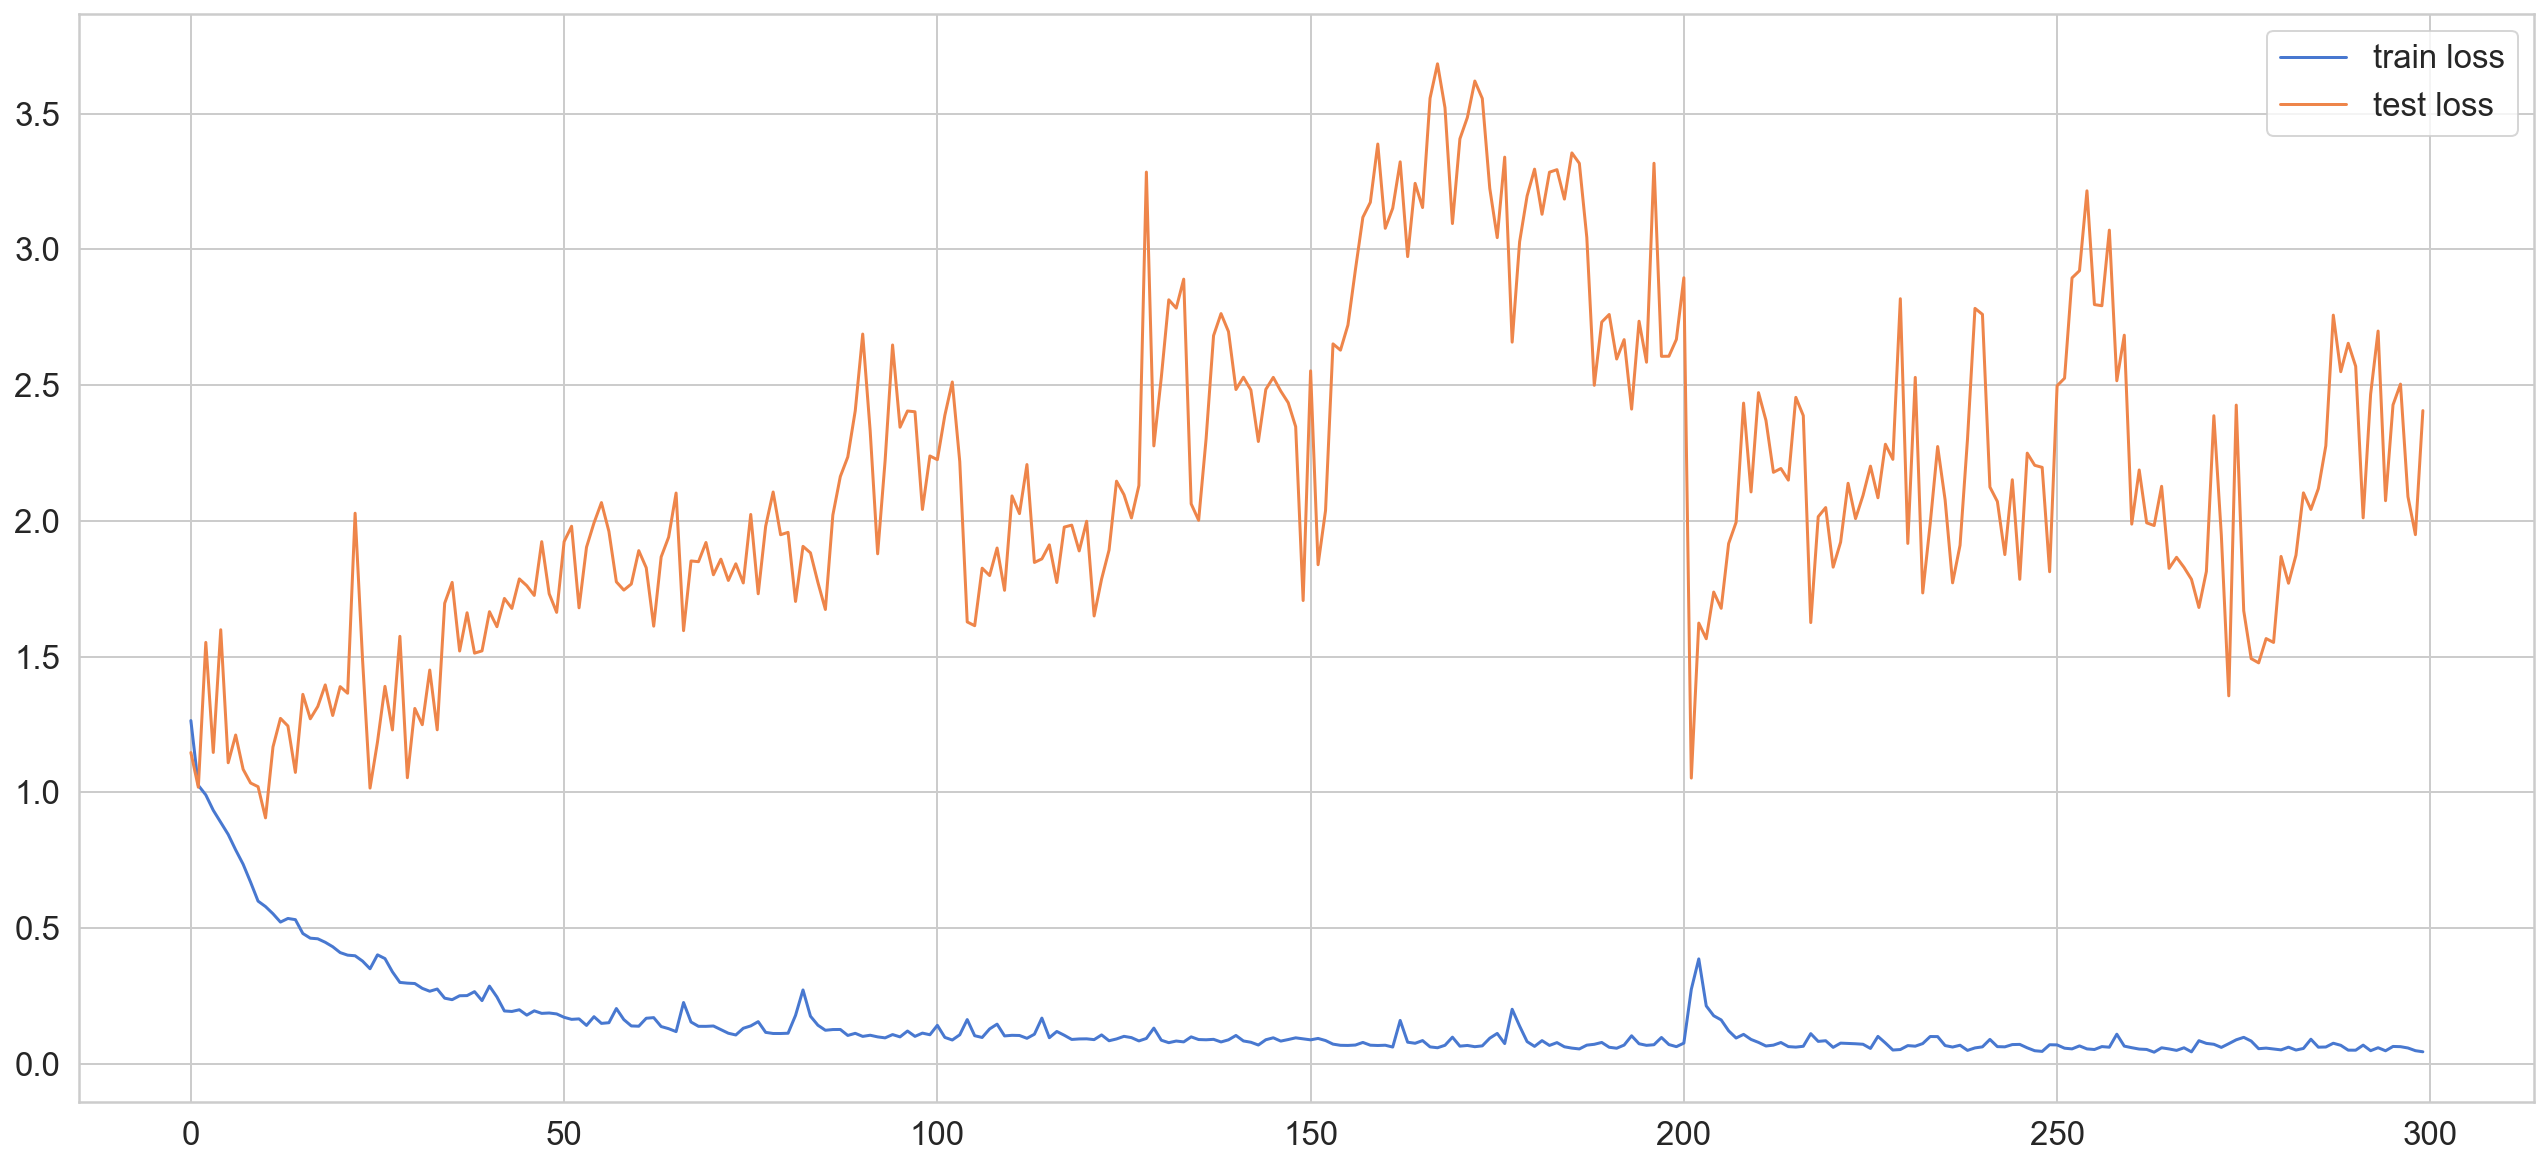

In [10]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

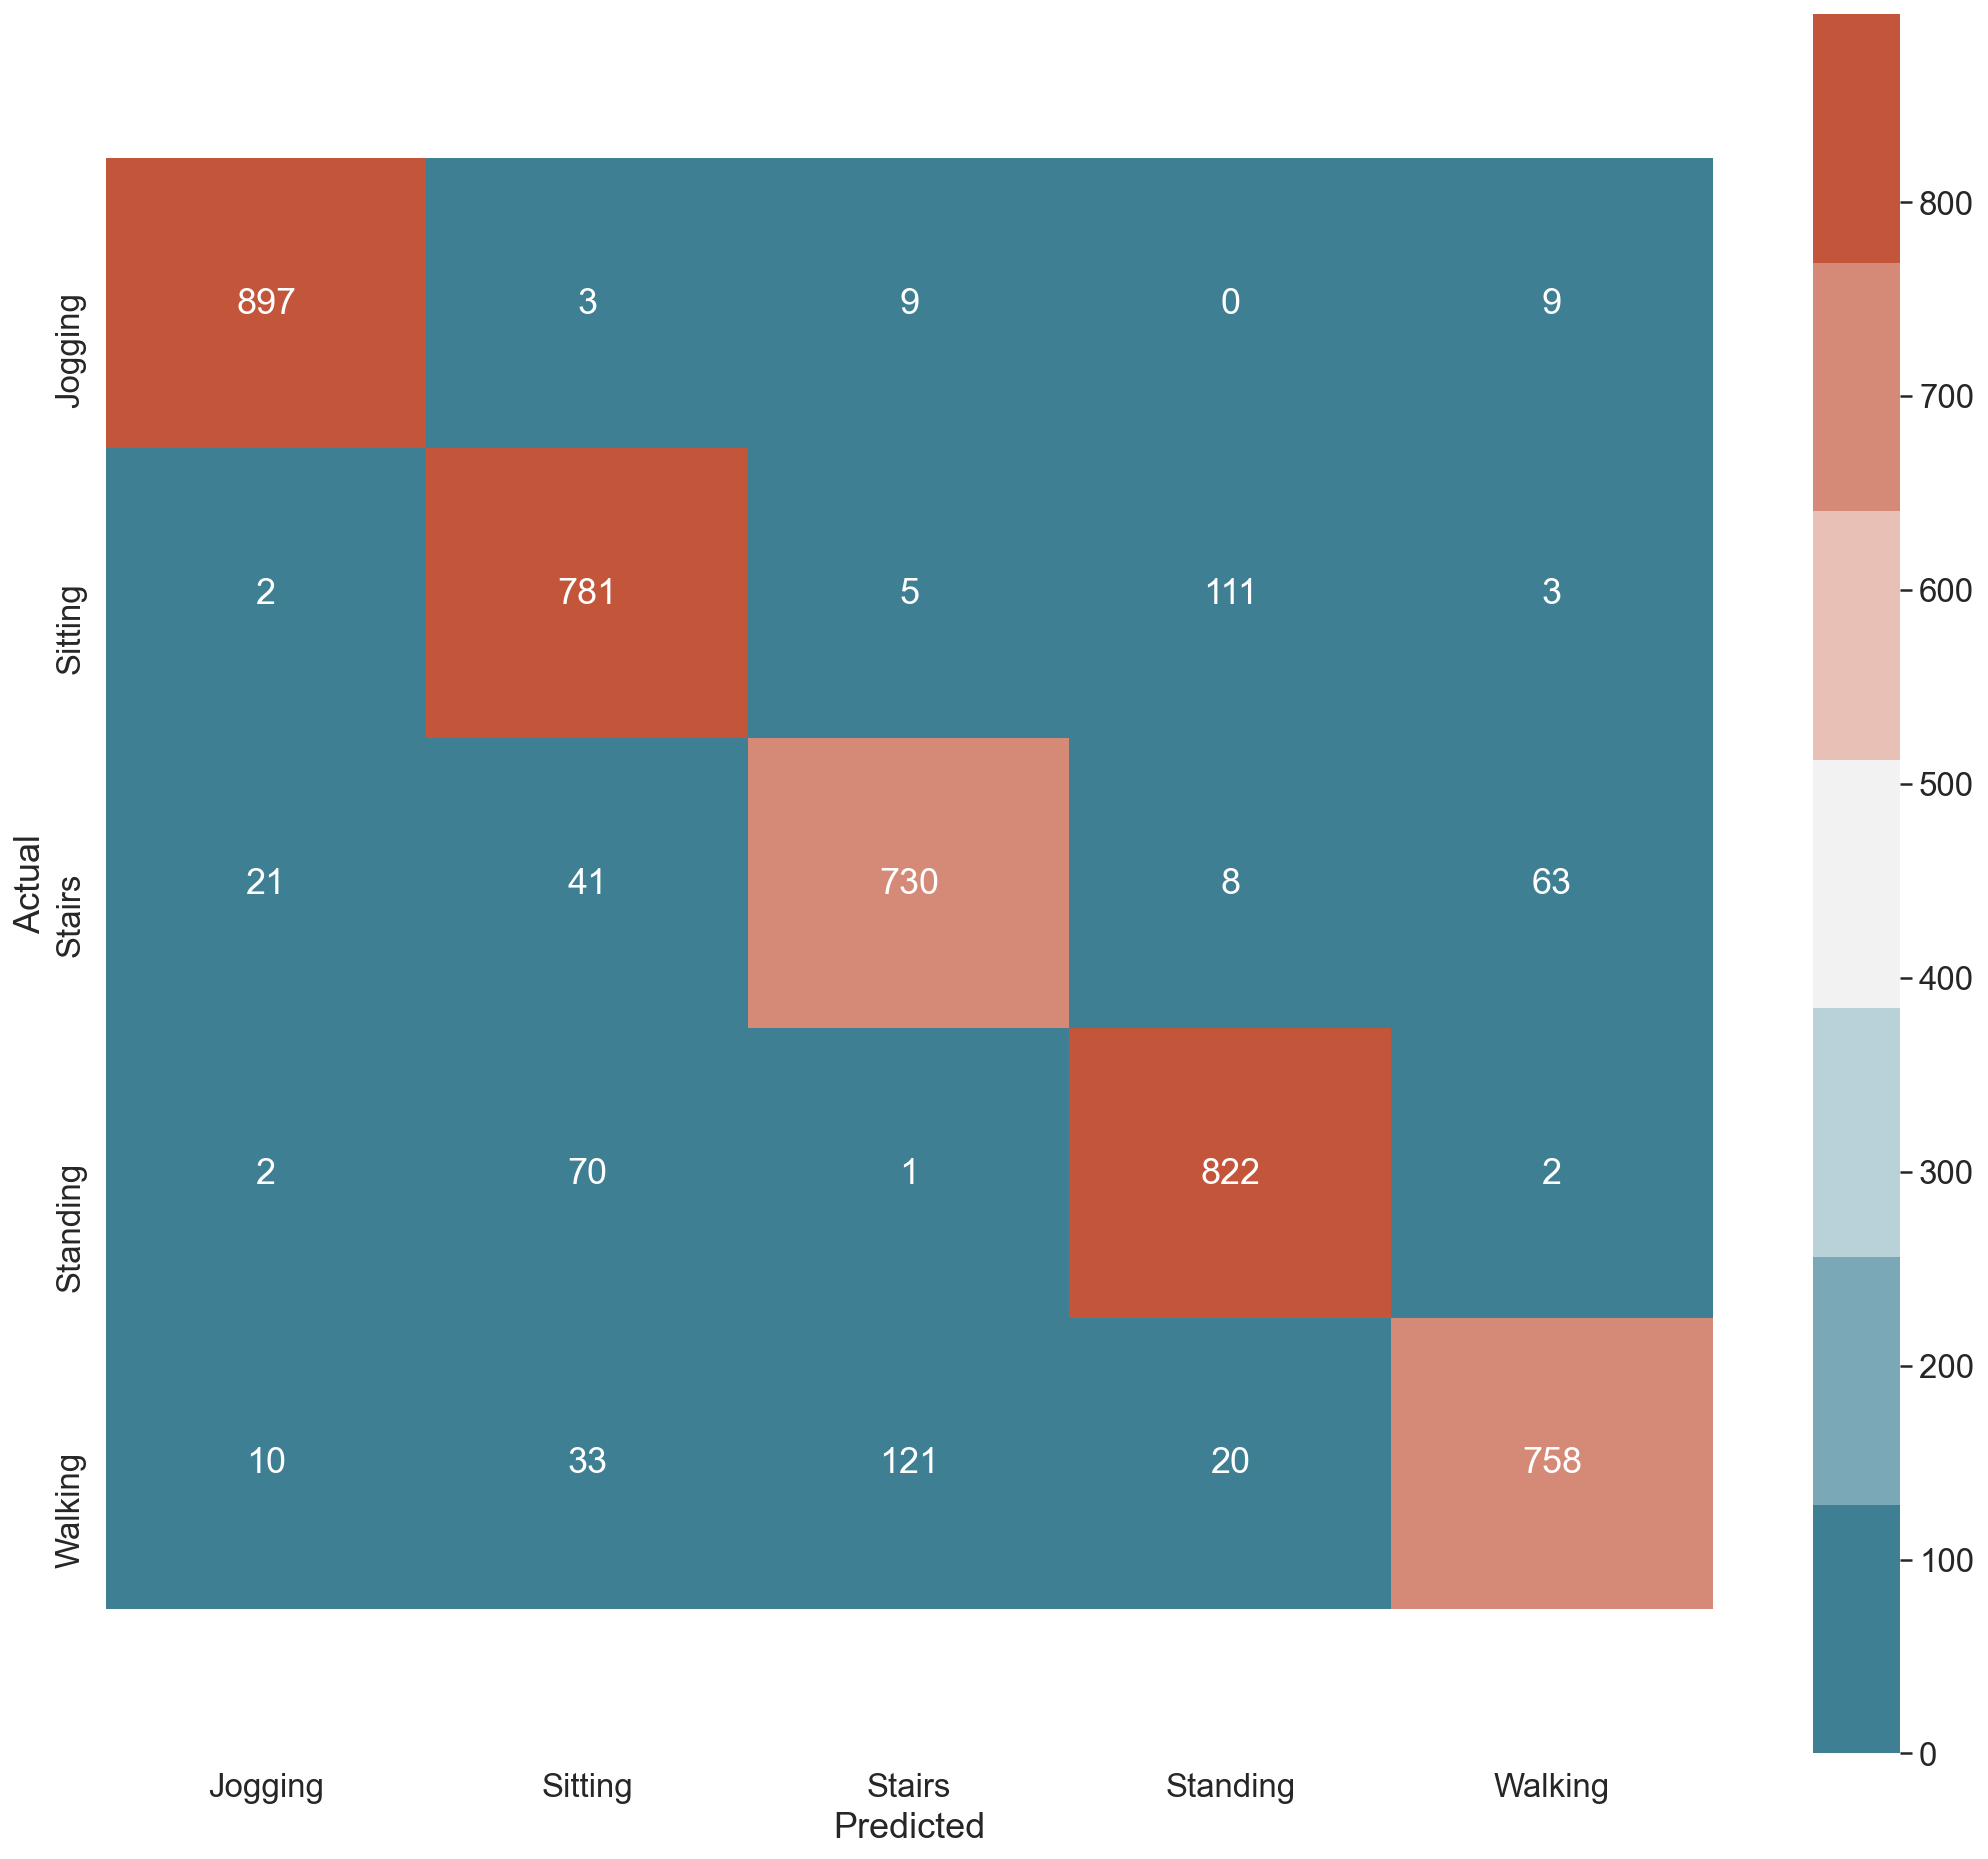

In [11]:
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [12]:
# Exporting the model

model.save("lifestyle_model.h5")

#reloading saved model
new_model = tf.keras.models.load_model('lifestyle_model.h5')
new_model.summary()

print("\nmain model result ///////////////////////////////////////////////////////")
model.evaluate(X_test, y_test) # main model result

print("\nsaved and loaded model result ///////////////////////////////////////////////////////")
new_model.evaluate(X_test, y_test) # saved and loaded model result

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 84,741
Trainable params: 84,741
Non-trainable params: 0
_________________________________________________________________

main model result ///////////////////////////////////////////////////////
142/142 [==============================] - 3s 23ms/step - loss: 0.7323 - acc: 0.8819

saved and loaded model result ///////////////////////////////////////////////////////
142

[0.7322720289230347, 0.8819106817245483]

In [13]:
# import os
# from tensorflow.python.tools import freeze_graph
# from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
    
# # Convert Keras model to ConcreteFunction
# full_model = tf.function(lambda x: model(x))
# full_model = full_model.get_concrete_function(
#     tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# # Get frozen ConcreteFunction
# frozen_func = convert_variables_to_constants_v2(full_model)
# frozen_func.graph.as_graph_def()

# layers = [op.name for op in frozen_func.graph.get_operations()]
# print("-" * 50)
# print("Frozen model layers: ")
# for layer in layers:
#     print(layer)

# print("-" * 50)
# print("Frozen model inputs: ")
# print(frozen_func.inputs)
# print("Frozen model outputs: ")
# print(frozen_func.outputs)

# # Save frozen graph from frozen ConcreteFunction to hard drive
# tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
#                   logdir="./frozen_models",
#                   name="frozen_graph.pb",
#                   as_text=False)